## Data Drift

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp


## Coviariate Drift

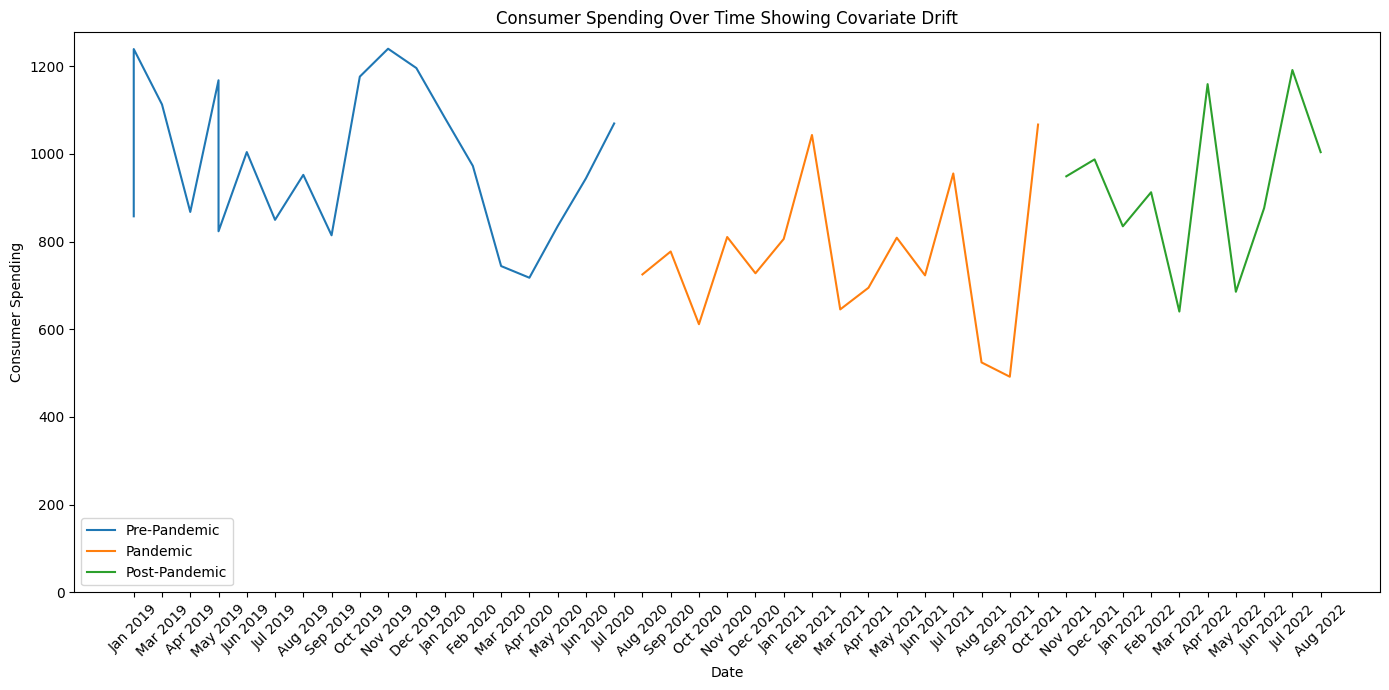

In [3]:


# Assuming the provided code snippet is correct and these values are defined somewhere in the code
pre_pandemic_months = 20  # Example value
pandemic_months = 15       # Example value
post_pandemic_months = 10  # Example value

# Generate data
# Pre-pandemic spending behavior
pre_pandemic_spending = np.random.normal(1000, 150, pre_pandemic_months)

# Pandemic spending behavior - assume a decrease in spending
pandemic_spending = np.random.normal(700, 200, pandemic_months)

# Post-pandemic spending behavior - could be a new normal
post_pandemic_spending = np.random.normal(950, 180, post_pandemic_months)

# Combine all data
total_spending = np.concatenate([pre_pandemic_spending, pandemic_spending, post_pandemic_spending])
time_period = np.arange(len(total_spending))

# Create DataFrame
df = pd.DataFrame({
    'Month': time_period,
    'Consumer Spending': total_spending
})

# Add a column to indicate the period
df['Period'] = 'Pre-Pandemic'
df.loc[df['Month'] >= pre_pandemic_months, 'Period'] = 'Pandemic'
df.loc[df['Month'] >= pre_pandemic_months + pandemic_months, 'Period'] = 'Post-Pandemic'

# Define a start date for the pre-pandemic period
start_date = datetime(2019, 1, 1)

# Create a date range for the x-axis labels
date_range = [start_date + timedelta(days=30*x) for x in df['Month']]

# Convert date_range to "Month Year" format
df['Date'] = [date.strftime('%b %Y') for date in date_range]

# Plotting
plt.figure(figsize=(14, 7))
for period in ['Pre-Pandemic', 'Pandemic', 'Post-Pandemic']:
    subset = df[df['Period'] == period]
    plt.plot(subset['Date'], subset['Consumer Spending'], label=period)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# # Labelling the first and last points of the lines
# plt.text(df['Date'][0], df['Consumer Spending'][0], df['Date'][0], ha='center', va='bottom')
# plt.text(df['Date'].iloc[-1], df['Consumer Spending'].iloc[-1], df['Date'].iloc[-1], ha='center', va='bottom')

plt.xlabel('Date')
plt.ylabel('Consumer Spending')
plt.title('Consumer Spending Over Time Showing Covariate Drift')
plt.ylim(bottom=0)  # Set the bottom y-axis limit to 0
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


## Prior Probability Drift

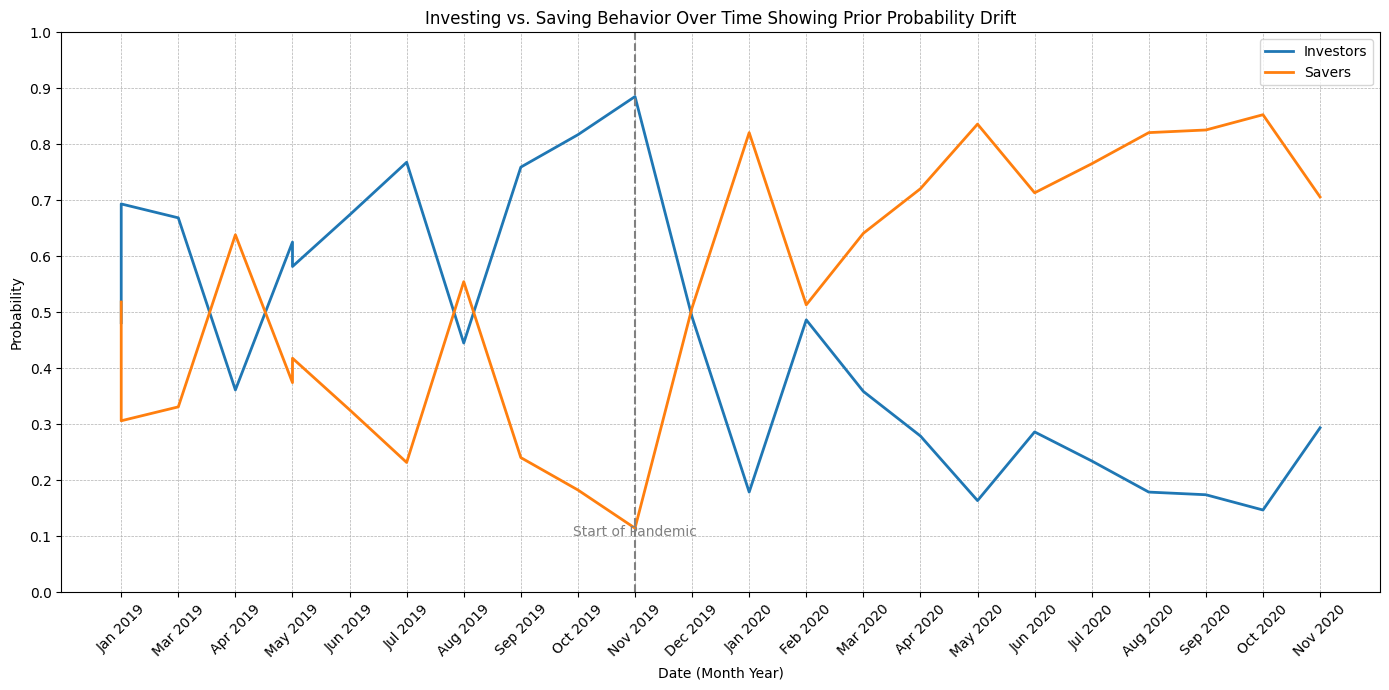

In [1]:

# Settings
months = 24  # 2 years

# Simulating investment behavior with a beta distribution
# The parameters a (alpha) and b (beta) control the shape of the distribution
a_investors_pre_pandemic = 7  # alpha > beta, skewed towards 1 (investing)
b_investors_pre_pandemic = 3

a_investors_during_pandemic = 3  # alpha < beta, skewed towards 0 (saving)
b_investors_during_pandemic = 7

# Generate continuous probabilities
investors_pre_pandemic = np.random.beta(a_investors_pre_pandemic, b_investors_pre_pandemic, months // 2)
savers_pre_pandemic = 1 - investors_pre_pandemic

investors_during_pandemic = np.random.beta(a_investors_during_pandemic, b_investors_during_pandemic, months // 2)
savers_during_pandemic = 1 - investors_during_pandemic

# Combine the data
investors = np.concatenate([investors_pre_pandemic, investors_during_pandemic])
savers = np.concatenate([savers_pre_pandemic, savers_during_pandemic])

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Month': np.arange(months) + 1,
    'Investors': investors,
    'Savers': savers
})

# Define a start date for the pre-pandemic period
start_date = datetime(2019, 1, 1)

# Create a date range for the x-axis labels
date_range = [start_date + timedelta(days=30*x) for x in range(months)]

# Convert date_range to "Month Year" format
df['Date'] = [date.strftime('%b %Y') for date in date_range]

# Plotting
plt.figure(figsize=(14, 7))

plt.plot(df['Date'], df['Investors'], label='Investors', linewidth=2)
plt.plot(df['Date'], df['Savers'], label='Savers', linewidth=2)

# Adding annotations for pandemic period
pandemic_start_date = df['Date'][months // 2 - 1]  # Assuming the pandemic starts at the halfway point

plt.axvline(x=pandemic_start_date, color='grey', linestyle='--')
plt.text(pandemic_start_date, 0.1, 'Start of Pandemic', horizontalalignment='center', color='grey')

# Improving the axes
plt.xlabel('Date (Month Year)')
plt.ylabel('Probability')
plt.title('Investing vs. Saving Behavior Over Time Showing Prior Probability Drift')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set y ticks to be in increments of 0.1
plt.yticks(np.linspace(0, 1, 11))

# Adding gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Ensure the legend is clear and placed appropriately
plt.legend(loc='best')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


## Population Stability Index

In [ ]:
def calculate_psi(expected, observed, bins=10):
    # Bin the data to get the distribution in each bin
    expected_counts, bin_edges = np.histogram(expected, bins=bins, range=(0, 1))
    observed_counts, _ = np.histogram(observed, bins=bin_edges, range=(0, 1))

    # Calculate the proportions of observations in each bin
    expected_proportions = expected_counts / sum(expected_counts)
    observed_proportions = observed_counts / sum(observed_counts)

    # Replace 0s with a small number to avoid division by zero in PSI calculation
    expected_proportions = np.where(expected_proportions == 0, 0.0001, expected_proportions)
    observed_proportions = np.where(observed_proportions == 0, 0.0001, observed_proportions)

    # Calculate the PSI
    psi_values = (expected_proportions - observed_proportions) * np.log(expected_proportions / observed_proportions)
    psi = sum(psi_values)

    return psi


psi = calculate_psi(investors_pre_pandemic, investors_during_pandemic)
print(f"Population Stability Index: {psi}")
if psi < 0.1:
    print("There is no significant shift.")
elif 0.1 <= psi <= 0.25:
    print("There is a moderate shift.")
else:
  print("There is a significant shift.")


Population Stability Index: 12.069684579465711
There is a significant shift.


## Statistical Testing

In [ ]:
# Split the data into two samples
pre_pandemic = df[df['Month'] <= 12]['Investors']
during_pandemic = df[df['Month'] > 12]['Investors']

# Perform Kolmogorov-Smirnov Test
ks_statistic, p_value = ks_2samp(pre_pandemic, during_pandemic)

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05  # Set a threshold for significance
if p_value < alpha:
    print("There is a significant difference between the two distributions. Data drift may have occurred.")
else:
    print("There is no significant difference between the two distributions. Data drift may not have occurred.")


KS Statistic: 0.9166666666666666
P-value: 1.77504552252163e-05
There is a significant difference between the two distributions. Data drift may have occurred.


In [ ]:
# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(pre_pandemic, during_pandemic)

stat, p_value
print(f"stat,: {ks_statistic}")
print(f"P-value: {p_value}")
# Interpret the p-value
alpha = 0.05  # Set a threshold for significance
if p_value < alpha:
    print("There is a significant difference between the two distributions. Data drift may have occurred.")
else:
    print("There is no significant difference between the two distributions. Data drift may not have occurred.")

stat,: 0.9166666666666666
P-value: 6.0057602968049e-05
There is a significant difference between the two distributions. Data drift may have occurred.
